In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [ ]:
ls

MyDrive/  Shareddrives/


In [ ]:
cd/gdrive/My Drive/RA Disease/

/gdrive/My Drive/RA Disease


In [ ]:
ls

RA/


In [ ]:
cd/gdrive/My Drive/RA Disease/RA/

/gdrive/My Drive/RA Disease/RA


In [ ]:
ls

auto_test/  test/  train/  val/


Import Libraries

In [ ]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input 
from tensorflow.python.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.python.keras.applications.efficientnet import EfficientNetB6, preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

In [ ]:
data = '/gdrive/My Drive/RA Disease/RA'
classes = ["auto_test", "test","train", "val"]

In [ ]:
base_dir = "/gdrive/My Drive/RA Disease/RA"
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir, 'test')

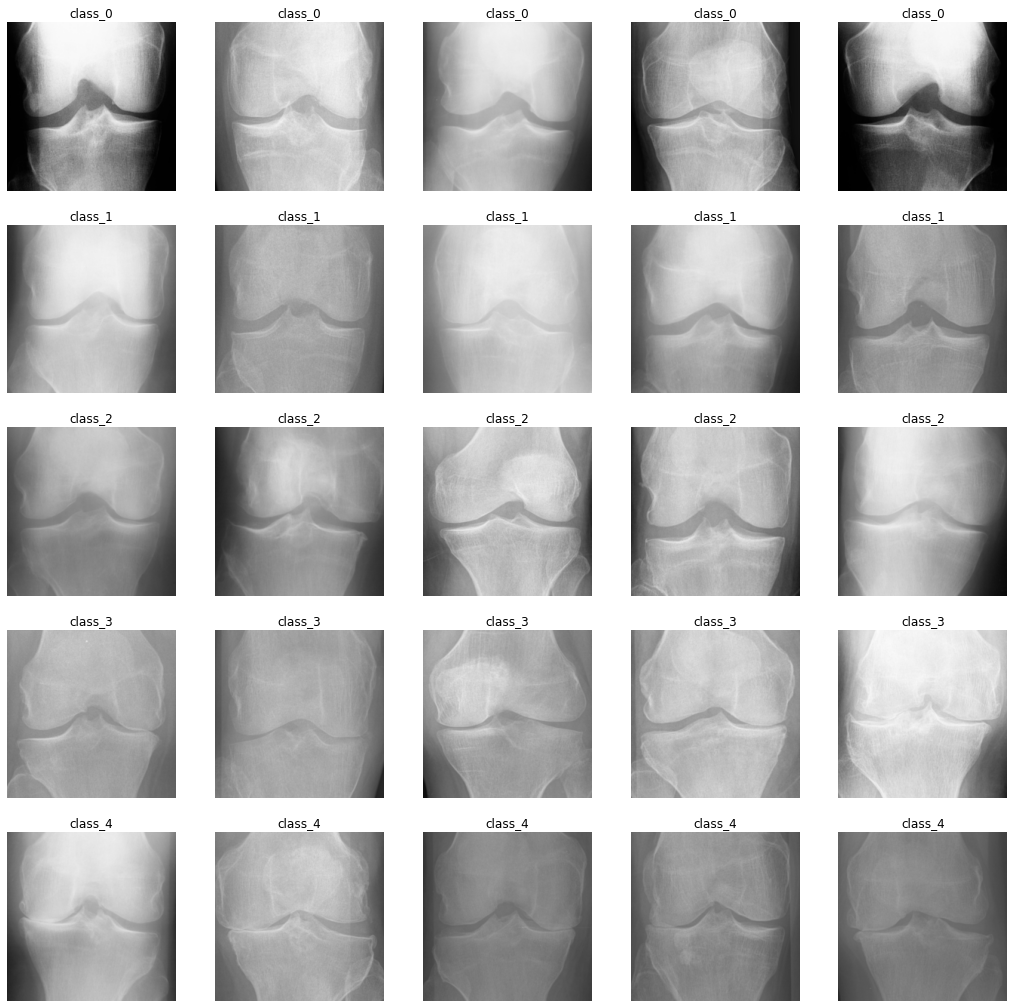

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(18,18))
for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()  
plt.show()

Distribution

In [ ]:
def show_distribution(folder):
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)
print("The distribution for the training data is :\n")
show_distribution(train_dir)

The distribution for the training data is :

Found 180 images belonging to 5 classes.
0 20.0
1 20.0
2 20.0
3 20.0
4 20.0


In [ ]:
print("The distribution for the validation data is :\n")
show_distribution(val_dir)

The distribution for the validation data is :

Found 171 images belonging to 5 classes.
0 21.05
1 21.05
2 21.05
3 21.05
4 15.79


In [ ]:
print("The distribution for the test data is :\n")
show_distribution(test_dir)

The distribution for the test data is :

Found 180 images belonging to 5 classes.
0 20.0
1 20.0
2 20.0
3 20.0
4 20.0


Dealing with imbalance classes

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\nThe class weights are : \n\n", class_weights)

Found 180 images belonging to 5 classes.

The class weights are : 

 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


Check the size of Image

In [ ]:
folder = os.path.join(train_dir,'0')
os.chdir(folder)
samples = random.sample(os.listdir(folder), 5)
for filename in samples:
    image = cv2.imread(filename)
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


Build model

In [ ]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [ ]:
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,    
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )
# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )
# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True
                                                  )
# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 180 images belonging to 5 classes.
Found 171 images belonging to 5 classes.
Found 180 images belonging to 5 classes.


In [ ]:
base_model = MobileNetV2(input_shape=IMAGE_SIZE + [3],
                            include_top=False,
                            weights='imagenet',
                            pooling='avg'
                           )
for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
experimental_run_tf_function=False

In [ ]:
import numpy as np

In [ ]:
x_input = base_model.input

x = Dense(128,activation='relu')(x_input)
x = Dropout(0.2)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(x_input, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

TypeError: ignored